In [144]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.autograd.functional import jacobian
from torch.func import jacrev, jacfwd
from tqdm import tqdm

In [145]:
NODE_NUM = 50
TIME_STEPS = 100
torch.set_default_dtype(torch.float64)

In [146]:
# Define the system
class FSystem:
    def __init__(self):
        self.f = lambda x: torch.sin(x) + x
         
    def func(self, x):
        x = torch.tensor(x)
        return self.f(x).numpy()
    
    def jacobian(self, x):
        x = torch.tensor(x)
        f_jac = torch.vmap(jacfwd(self.f))
        return f_jac(x).numpy()

In [147]:
class HSystem:
    def __init__(self, node_num=NODE_NUM):
        self.h1 = lambda x: torch.tensor([0., 1.]) @ (x ** 1.2)
        self.h2 = lambda x: torch.tensor([1., 0.]) @ (x * torch.tanh(x))
        self.node_classification = torch.tensor(np.random.binomial(1, 0.5, (node_num,1)))
        
    def func(self, x, n_expansions=0):
        x = torch.Tensor(x)
        node_classification = self.node_classification
        for i in range(n_expansions):
            node_classification = node_classification[:, None]
        result = node_classification * self.h1(x) + (1 - node_classification) * self.h2(x)
        return result.numpy()
    
    def jacobian(self, x, n_expansions=0):
        x = torch.Tensor(x)
        h1_jac = torch.vmap(jacfwd(self.h1))
        h2_jac = torch.vmap(jacfwd(self.h2))
        node_classification = self.node_classification
        for i in range(n_expansions):
            node_classification = node_classification[:, None]
        result = node_classification * h1_jac(x) + (1 -node_classification) * h2_jac(x)
        return result.numpy()

In [148]:
h = HSystem()
h_func = h.h1
node_clf = h.node_classification
h_jac = torch.vmap(jacfwd(h_func))
# h_jac(torch.ones(1,2, 1)).shape
# node_clf[:, None].shape
(node_clf[:, None] * h_jac(torch.ones(1, 2, 1)) + (1 -node_clf[:, None]) * h_jac(torch.ones(1, 2, 1))).shape

torch.Size([1, 50, 2, 1])

In [149]:
def generate_data_points(f, q, x0, n_point):
    noise_shape = x0.shape + (n_point,)
    w = q * np.random.randn(*noise_shape)
    data_points = np.zeros(shape=noise_shape)
    x = x0
    for i in range(n_point):
        x = f(x) + w[..., i]
        data_points[..., i] = x
    return data_points

def generate_measurements(h, data_points, r_array):
    z = h(data_points, n_expansions=1)
    noise_shape = z.shape
    # print(z)
    v = r_array[:, None,None] * np.random.randn(*noise_shape)
    measurements = z + v
    return  measurements

In [150]:
def centralized_extended_kalman_filter(measurements, f_system, h_system, r_array, q, P0, x0):
    x_hat = np.zeros((TIME_STEPS, 2, 1))
    measurements = measurements.transpose(2, 0, 1)
    R_inv = 1 / (r_array**2)
    P = P0
    x_pred = x0
    for i in range(measurements.shape[0]):
        H_T = h_system.jacobian(x_pred[None,...], 1)[0, ...]
        H = H_T.transpose((0, 2, 1))
        node_s = H_T @ R_inv[:, None, None] @ H
        y_node = H_T @ R_inv[:, None, None] @ measurements[i, ...,None]
        y_pred = H_T @ R_inv[:, None, None] @ h_system.func(x_pred[None,...], 1)
        s_all = np.sum(node_s, axis=0) / NODE_NUM
        y_all_delta = np.sum(y_node - y_pred, axis=0) / NODE_NUM
        M = np.linalg.inv(np.linalg.inv(P) + s_all)
        x_current = x_pred + M @ y_all_delta
        F = f_system.jacobian(x_current[None, ..., 0])[0, ...]
        P = F @ M @ F.T + NODE_NUM * q**2 * np.eye(2)
        x_pred = f_system.func(x_current)
        x_hat[i, ...] = x_current
    return x_hat

In [161]:
def diffusion_extended_kalman_filter(measurements, f_system, h_system, r_array, q, P0, x0, j_matrix):
    x_hat = np.zeros((TIME_STEPS, NODE_NUM, 2, 1))
    R_inv = 1 / (r_array**2)
    measurements = measurements.transpose(2, 0, 1)
    P = j_matrix.sum(axis=0)[..., None, None] * P0
    x_pred = x0
    for i in range(measurements.shape[0]):
        x_current_list = []
        M_list = []
        if i == 0:
            x_pred = x_pred[None, ...].repeat(NODE_NUM, axis=0)
        H_T = h_system.jacobian(x_pred, 1)
        H = H_T.transpose((0, 1, 3, 2))
        for j in range(NODE_NUM):
            x_pred_j = x_pred[j, ...][None, ...]
            H_T_j = H_T[j, ...]
            H_j = H[j, ...]
            node_s = H_T_j @ R_inv[:, None, None] @ H_j
            y_node_j = H_T_j @ R_inv[:, None, None] @ measurements[i, ...,None]
            y_pred_j = H_T_j @ R_inv[:, None, None] @ h_system.func(x_pred_j[None,...], 1)
            s_local_j = (j_matrix[:, j, None, None] * node_s).sum(0) / j_matrix[:, j].sum()
            y_local_delta_j = (j_matrix[:, j, None, None] * (y_node_j - y_pred_j)).sum(0) / j_matrix[:, j].sum()
            M_j = np.linalg.inv(np.linalg.inv(P[j, ...]) + s_local_j)
            x_current_j = (x_pred_j + M_j @ y_local_delta_j)[0, ...]
            x_current_list.append(x_current_j)
            M_list.append(M_j)
        x_current_all = np.stack(x_current_list, axis=0)
        M_all = np.stack(M_list, axis=0)
        x_current = np.einsum('ij, jmk -> imk', j_matrix, x_current_all) / j_matrix.sum(axis=0)[..., None, None]
        F = f_system.jacobian(x_current[..., 0])
        P = F @ M_all @ F.transpose((0, 2, 1)) + j_matrix.sum(axis=0)[..., None, None] * q**2 * np.eye(2)
        x_pred = f_system.func(x_current)
        x_hat[i, ...] = x_current
    return x_hat

In [ ]:
h_system.func(x_pred_j[None,...], 1)[:,0,:] - h_system.func(x_pred, 1)[:,j,:]

In [152]:
def local_extended_kalman_filter2(measurements, f_system, h_system, r_array, q, P0, x0, j_matrix):
    x_hat = np.zeros((TIME_STEPS, NODE_NUM, 2, 1))
    R_inv = 1 / (r_array**2)
    measurements = measurements.transpose(2, 0, 1)
    P = j_matrix.sum(axis=0)[..., None, None] * P0
    x_pred = x0
    for i in range(measurements.shape[0]):
        x_current_list = []
        M_list = []
        if i == 0:
            x_pred = x_pred[None, ...].repeat(NODE_NUM, axis=0)
        H_T = h_system.jacobian(x_pred, 1)
        H = H_T.transpose((0, 1, 3, 2))
        for j in range(NODE_NUM):
            x_pred_j = x_pred[j, ...][None, ...]
            H_T_j = H_T[j, ...]
            H_j = H[j, ...]
            node_s = H_T_j @ R_inv[:, None, None] @ H_j
            y_node_j = H_T_j @ R_inv[:, None, None] @ measurements[i, ...,None]
            y_pred_j = H_T_j @ R_inv[:, None, None] @ h_system.func(x_pred_j[None,...], 1)
            s_local_j = (j_matrix[:, j, None, None] * node_s).sum(0) / j_matrix[:, j].sum()
            y_local_delta_j = (j_matrix[:, j, None, None] * (y_node_j - y_pred_j)).sum(0) / j_matrix[:, j].sum()
            M_j = np.linalg.inv(np.linalg.inv(P[j, ...]) + s_local_j)
            x_current_j = (x_pred_j + M_j @ y_local_delta_j)[0, ...]
            x_current_list.append(x_current_j)
            M_list.append(M_j)
        x_current_all = np.stack(x_current_list, axis=0)
        M_all = np.stack(M_list, axis=0)
        F = f_system.jacobian(x_current_all[..., 0])
        P = F @ M_all @ F.transpose((0, 2, 1)) + j_matrix.sum(axis=0)[..., None, None] * q**2 * np.eye(2)
        x_pred = f_system.func(x_current_all)
        x_hat[i, ...] = x_current_all
    return x_hat

In [153]:
def alg_3_extended_kalman_filter2(measurements, f_system, h_system, r_array, q, P0, x0, j_matrix, eps=0.2):
    x_hat = np.zeros((TIME_STEPS, NODE_NUM, 2, 1))
    R_inv = 1 / (r_array**2)
    measurements = measurements.transpose(2, 0, 1)
    P = j_matrix.sum(axis=0)[..., None, None] * P0
    x_pred = x0
    for i in range(measurements.shape[0]):
        x_current_list = []
        M_list = []
        if i == 0:
            x_pred = x_pred[None, ...].repeat(NODE_NUM, axis=0)
        H_T = h_system.jacobian(x_pred, 1)
        H = H_T.transpose((0, 1, 3, 2))
        for j in range(NODE_NUM):
            x_pred_j = x_pred[j, ...][None, ...]
            H_T_j = H_T[j, ...]
            H_j = H[j, ...]
            node_s = H_T_j @ R_inv[:, None, None] @ H_j
            y_node_j = H_T_j @ R_inv[:, None, None] @ measurements[i, ...,None]
            y_pred_j = H_T_j @ R_inv[:, None, None] @ h_system.func(x_pred_j[None,...], 1)
            s_local_j = (j_matrix[:, j, None, None] * node_s).sum(0) / j_matrix[:, j].sum()
            y_local_delta_j = (j_matrix[:, j, None, None] * (y_node_j - y_pred_j)).sum(0) / j_matrix[:, j].sum()
            M_j = np.linalg.inv(np.linalg.inv(P[j, ...]) + s_local_j)
            x_current_j = (x_pred_j + M_j @ y_local_delta_j)[0, ...]
            x_current_list.append(x_current_j)
            M_list.append(M_j)
        x_diff_pred_neighborhood = (np.einsum('ij, jmk -> imk', j_matrix, x_pred) - j_matrix.sum(axis=0)[..., None, None] * x_pred)
        x_diff_pred_neighborhood = x_diff_pred_neighborhood / j_matrix.sum(axis=0)[..., None, None]
        x_current_all = np.stack(x_current_list, axis=0) + eps * x_diff_pred_neighborhood
        M_all = np.stack(M_list, axis=0)
        F = f_system.jacobian(x_current_all[..., 0])
        P = F @ M_all @ F.transpose((0, 2, 1)) + j_matrix.sum(axis=0)[..., None, None] * q**2 * np.eye(2)
        x_pred = f_system.func(x_current_all)
        x_hat[i, ...] = x_current_all
    return x_hat

In [165]:
h_sys = HSystem()
f_sys = FSystem()
g = nx.connected_watts_strogatz_graph(NODE_NUM, 5, 0.4, seed=42)
g.add_edges_from([(i, i) for i in range(NODE_NUM)])

In [179]:
adj_matrix = nx.adjacency_matrix(g).todense()

(50, 50, 50)

In [160]:
x_hat_kalman_list3 = []
x_hat_local_kalman_list = []
x_hat_diffusion_kalman_list = []
x_hat_alg_3_list = []
x_points_list = []
q = 1
P0 = 1 *np.eye(2)
x0 = np.array([[1, 1],]).T
x_points = generate_data_points(f_sys.func, q, np.array([10, 10]).T, TIME_STEPS)
for i in tqdm(range(1)):
    r_array = (np.linspace(1, NODE_NUM, NODE_NUM))**0.5
    x_points_list.append(x_points.T)
    meas = generate_measurements(h_sys.func, x_points, r_array)
    adj_matrix = nx.adjacency_matrix(g)
    x_hat_kalman3 = centralized_extended_kalman_filter(meas, f_sys, h_sys, r_array, q, P0, x0)
    x_hat_local_kalman = local_extended_kalman_filter2(meas, f_sys, h_sys, r_array, q, P0, x0, j_matrix)
    x_hat_diffusion_kalman = diffusion_extended_kalman_filter(meas, f_sys, h_sys, r_array, q, P0, x0, j_matrix)
    x_hat_alg_3 = alg_3_extended_kalman_filter2(meas, f_sys, h_sys, r_array, q, P0, x0, j_matrix)
    x_hat_kalman_list3.append(x_hat_kalman3)
    x_hat_local_kalman_list.append(x_hat_local_kalman)
    x_hat_alg_3_list.append(x_hat_alg_3)
    x_hat_diffusion_kalman_list.append(x_hat_diffusion_kalman)
x_points = np.stack(x_points_list, axis=0)
x_hat_kalman3 = np.stack(x_hat_kalman_list3, axis=0)
x_hat_diffusion_kalman = np.stack(x_hat_diffusion_kalman_list, axis=0)
x_hat_local_kalman = np.stack(x_hat_local_kalman_list, axis=0)
x_hat_alg_3 = np.stack(x_hat_alg_3_list, axis=0)

  0%|          | 0/1 [14:28<?, ?it/s]


KeyboardInterrupt: 

In [172]:

# err_kalman = np.linalg.norm(x_hat_kalman - x_points.T[..., None], axis=(-1,-2)).mean(axis=0)
# err_kalman2 = np.linalg.norm(x_hat_kalman2 - x_points.T[..., None], axis=(-1,-2)).mean(axis=0)
err_kalman3 = np.linalg.norm(x_hat_kalman3 - x_points[..., None], axis=(-1,-2)).mean(axis=0)
err_local_kalman = np.linalg.norm(x_hat_local_kalman - x_points[:, :, None, ..., None].repeat(NODE_NUM, axis=2), axis=(-1,-2)).mean(axis=(0, 2))
err_local_kalman2 = np.linalg.norm(x_hat_diffusion_kalman - x_points[:, :, None,..., None].repeat(NODE_NUM, axis=2), axis=(-1,-2)).mean(axis=(0, 2))
err_alg_3 = np.linalg.norm(x_hat_alg_3 - x_points[:, :, None, ..., None].repeat(NODE_NUM, axis=2), axis=(-1,-2)).mean(axis=(0, 2))
# err_alg_3 = np.linalg.norm(x_hat_alg_3 - x_points.T[:, None,..., None].repeat(NODE_NUM, axis=1), axis=(-1,-2)).mean(axis=1)

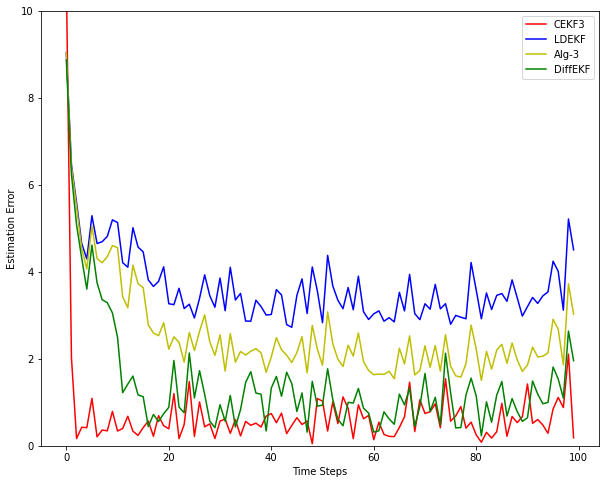

In [173]:
plt.figure(figsize=(10, 8))
# plt.plot(err_kalman, 'r', label='CEKF')
# plt.plot(err_kalman2, 'g', label='CEKF2')
plt.plot(err_kalman3, 'r', label='CEKF3')
plt.plot(err_local_kalman, 'b', label='LDEKF')
plt.plot(err_alg_3, 'y', label='Alg-3')
plt.plot(err_local_kalman2, 'g', label='DiffEKF')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Estimation Error')
plt.ylim([0, 10])
# do log scale
# plt.yscale('log')
plt.show()

# Deep Extended Kalman Filter

In [45]:
import torch
from torch_geometric.nn import GATv2Conv, GCNConv
import pytorch_lightning as pl

In [80]:
gat = GATv2Conv(16, 64, heads=1, edge_dim=2, concat=False, dropout=0.0)

In [134]:
# create example for GATConv returning edge_attr
x = torch.randn(8, 16)
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 4, 5, 6, 7],
                            [1, 0, 2, 1, 3, 2, 5, 4, 7, 6]])
edge_attr = torch.randn(10, 2)

In [126]:
edge_index.shape

torch.Size([2, 10])

In [127]:
# forward pass
out = gat(x, edge_index, edge_attr, return_attention_weights=True)

In [128]:
len(out)

2

In [129]:
out[0].shape

torch.Size([8, 64])

In [130]:
out[1][1].shape

torch.Size([18, 1])

In [131]:
# implement ST_GAT Model using  pytorch_lightning
class ST_GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, edge_dim, node_kalman_dim, edge_kalman_dim, heads=1, dropout=0.0):
        super(ST_GAT, self).__init__()
        self.gat = GATv2Conv(in_channels, out_channels, heads=heads, edge_dim=edge_dim, dropout=dropout, concat=False)
        self.node_lstm = torch.nn.GRU(input_size=out_channels, hidden_size=node_kalman_dim, num_layers=1, batch_first=True)
        self.edge_lstm = torch.nn.GRU(input_size=heads, hidden_size=edge_kalman_dim, num_layers=1, batch_first=True)
        
    def forward(self, node_features, edge_index, edge_attr, node_hidden, edge_hidden):
        node_output, egde_output = self.gat(node_features, edge_index, edge_attr, return_attention_weights=True)
        edge_index, edge_attr = egde_output
        _, node_hidden = self.node_lstm(node_output.unsqueeze(1), node_hidden)
        _, edge_hidden = self.edge_lstm(edge_attr.unsqueeze(1), edge_hidden)
        return node_hidden, edge_hidden, edge_index
    

class GraphKalmanFilter(torch.nn.Module):
    def __init__(self, node_num, h_func, f_func, signal_dim, node_feature_dim, node_output_dim, edge_features_dim, node_kalman_dim, edge_kalman_dim, heads=1, dropout=0.0):
        super(GraphKalmanFilter, self).__init__()
        self.node_num = node_num
        self.gat_rnn = ST_GAT(node_feature_dim, node_output_dim, edge_features_dim, node_kalman_dim, edge_kalman_dim, heads, dropout)
        self.loss = torch.nn.MSELoss()
        self.gcn = GCNConv(signal_dim, signal_dim, aggr='mean')
        self.h = h_func
        self.f = f_func
    
    def forward(self, measurements, x_pred_t_1_t_1, x_pred_t_1_t_2, node_hidden, edge_index, edge_hidden):
        x_pred_t_t_1 = self.f(x_pred_t_1_t_1)
        y_pred_t_t_1 = self.h(x_pred_t_t_1, 1)
        # TODO: check the shape of the measurements minus y_pred_t_t_1 - the y_pred is unique for each node
        delta_y_t = measurements - y_pred_t_t_1
        delta_x_hat_t_1 = x_pred_t_1_t_1 - x_pred_t_1_t_2
        edge_features = delta_y_t[edge_index[0, :], edge_index[1, :], ...]
        node_kalman, edge_kalman, edge_index = self.gat_rnn(delta_x_hat_t_1, edge_index, edge_features, node_hidden, edge_hidden)
        phi_pred_t_t = x_pred_t_t_1 + node_kalman @ delta_y_t
        x_pred_t_t = self.gcn(phi_pred_t_t)
        return node_hidden, edge_hidden, edge_index


In [138]:
layer = ST_GAT(16, 64, 2, 32, 32, heads=1, dropout=0.0)
node_output, edge_attr_out, edge_index_out, node_hidden_out, edge_hidden_out = layer(
    x, edge_index, edge_attr, torch.randn(1, 8, 32), torch.randn(1, 18, 32))

In [119]:
len(out)

5

In [106]:
x.unsqueeze(1).shape

torch.Size([8, 1, 16])

In [164]:
edge_index

tensor([[0, 1, 1, 2, 2, 3, 4, 5, 6, 7],
        [1, 0, 2, 1, 3, 2, 5, 4, 7, 6]])

In [192]:
torch.tensor(adj_matrix)[*edge_index].shape

SyntaxError: invalid syntax (<ipython-input-192-0f7107a206d2>, line 1)

In [193]:
edge_index.shape

torch.Size([2, 10])

In [194]:
adj_matrix[edge_index[0, :], edge_index[1, :]].shape

(10,)

In [185]:
np.array([[0, 1, 1, 2, 2, 3, 4, 5, 6, 7],[0, 1, 1, 2, 2, 3, 4, 5, 6, 7]]).shape

(2, 10)